In [46]:
import dicom
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from skimage import draw


%matplotlib inline

In [2]:
main_directory = '/mnt/d/python-env-seminar/data/training-cancer-loc'
file_struct = os.walk(main_directory)
directories = []
files = []
for directory in file_struct:
    directories.append(directory[0])
    files.append(directory[2])

# directories contains a list of the patient directories
directories = directories[1:]
# files is a list of lists of all the files in the patient directories
files = files[1:]

print('{nb_patient} patients in total'.format(nb_patient=len(files)))

150 patients in total


In [3]:
def dicom_attribute_list(dicom_file):
    dicom_content = dicom.read_file(dicom_file)
    attribute_list = dicom_content.dir("")
    return attribute_list

def get_dicom_image(dicom_file):
    dicom_content = dicom.read_file(dicom_file)
    image_content = np.fromstring(dicom_content.PixelData, dtype=np.int16)
    dicom_image = image_content.reshape((dicom_content.Columns, dicom_content.Rows))
#     return numpy.fliplr(numpy.flipud(dicom_image))
    return dicom_image
    

In [4]:
roi_contour_tag = (0x3006, 0x0039)
contour_sequence_tag = (0x3006, 0x0040)
image_info_tag = (0x3006, 0x0016) 
image_id_tag = (0x0008, 0x1155)
contour_data_tag = (0x3006, 0x0050)


def get_tumor_index(dicom_content):
    """Returns the array position of the GTVp
    This index can then be used to access the relevant contour
    Usage : dicom_content[roi_contour_tag][get_tumor_index(dicom_content)]
    """
    # TODO handle the case when no GTVp tumor is segmented
    tumor_indexes = {}
    fof = None
    for seq in dicom_content.StructureSetROISequence:
        fof = seq.ReferencedFrameOfReferenceUID
        tumor_indexes[seq.ROIName] = int(seq.ROINumber) 
    return tumor_indexes['GTVp'] - 1


def get_tumor_image_name(dicom_content, slice_index):
    """
    Returns the ct name associated with current segmentation slice
    dicom_content should be the dicom object for the segmentation dicom file
    """
    tumor_index = get_tumor_index(dicom_content)
    return dicom_content[roi_contour_tag][tumor_index][contour_sequence_tag][slice_index][image_info_tag][0][image_id_tag].value

def get_tumor_segmentation(dicom_content, slice_index):
    """
    Extracts the segmentation values for a given slice
    dicom_content should be the dicom object for the segmentation dicom file
    """
    tumor_index = get_tumor_index(dicom_content)
    contour_raw = dicom_content[roi_contour_tag][tumor_index][contour_sequence_tag][slice_index][contour_data_tag].value
    coords_1 = np.asarray([float(contour_raw[i]) for i in range(0, len(contour_raw), 3)])
    coords_2 = np.asarray([float(contour_raw[i]) for i in range(1, len(contour_raw), 3)])
    return coords_1, coords_2

def plot_contour(contour_coords_1, contour_coords_2):
    """
    Plots the contour given x and y coordinates
    """
    plt.axes().set_aspect('equal')
    plt.plot(contour_coords_1, contour_coords_2)
    plt.show()

def poly2mask_(vertex_row_coords, vertex_col_coords, shape):
    """
    Converts vertices to a binary mask
    """
    fill_row_coords, fill_col_coords = draw.polygon(vertex_row_coords, vertex_col_coords, shape)
    mask = np.zeros(shape, dtype=np.bool)
    mask[fill_row_coords, fill_col_coords] = True
    return mask

def extract_from_mask_(mask, size, stride):
    """
    Extracts the upper left coordinates of all the patches that are fully in the mask
    """
    mask_coords_x, mask_coords_y = np.nonzero(mask)
    left  = np.min(mask_coords_x) 
    right = np.max(mask_coords_x) 
    up    = np.min(mask_coords_y) 
    down  = np.max(mask_coords_y) 
    squares = []
    for i in range(left, right - size + 1, stride):
        for j in range(up, down - size + 1, stride):
            candidate_square = mask[np.ix_(np.arange(i, i + size), np.arange(j, j + size))]
            # check if square entirely in the mask
            if np.sum(candidate_square) == size ** 2:
                squares.append((i, j))
    return squares

def extract_from_image(img, x_coords, y_coords, size, stride):
    """
    Returns numpy array of patches with shape size x size with index of patch in the first dimension
    """
    mask = poly2mask_(x_coords, y_coords, (512, 512)) # TODO: check if +255 OK
    if(np.sum(mask)>0):
        squares = extract_from_mask_(mask, size, stride)
        patches = np.zeros([len(squares), size, size])
        for k in range(len(squares)):
            i, j = squares[k]
            patches[k, :, :] = img[np.ix_(np.arange(i, i + size), np.arange(j, j + size))]
        return patches
    else:
        return []


In [57]:
def extract_all_patient_patches(patient_path, patch_size, display=False):
    """Extract all patches of a given size for a patient"""
    # Main file with segmentation is either str.dcm, STR.DCM, or /Str.dcm
    if os.path.isfile(patient_path + '/STR.DCM'):
        str_path = patient_path + '/STR.DCM'
    elif (os.path.isfile(patient_path + '/Str.dcm')):
        str_path = patient_path + '/Str.dcm'
    else:
        str_path = patient_path + '/str.dcm'
    segment_dicom = dicom.read_file(str_path)
    tumor_index = get_tumor_index(segment_dicom)
    nb_image = len(segment_dicom[roi_contour_tag][tumor_index][contour_sequence_tag].value)
    all_patches = []
    # Go through all images that are referenced in the segmentation
    # for each image, extract all the patches that match the requirements
    for image_index  in range(nb_image):
        dicom_name = get_tumor_image_name(segment_dicom, image_index)
        ct_file = patient_path + '/' + 'CT' + dicom_name + '.dcm'
        dicom_image = get_dicom_image(ct_file)
        dicom_content = dicom.read_file(ct_file)
        # Get patient position and spacing between pixels
        patient_position = dicom_content.ImagePositionPatient
        patient_position = [float(position) for position in patient_position]
        ox, oy, oz = patient_position
        
        # Get patient spacing between pixels
        patient_spacings = dicom_content.PixelSpacing
        patient_spacings = [float(space) for space in patient_spacings]
        sx, sy = patient_spacings
        
        # transform contour coordinates according to patient data
        x_coords, y_coords  = get_tumor_segmentation(segment_dicom, image_index)
        x_coords = np.asarray([(pos - ox) / sx for pos in x_coords])
        y_coords = np.asarray([(pos - oy) / sy for pos in y_coords])
        
        # Display segmentation
        if(display):
            plt.imshow(dicom_image, cmap='gray')
            plt.plot(x_coords, y_coords)
            plt.show()
        
        # Extract patches
        image_patches = extract_from_image(dicom_image, x_coords, y_coords, patch_size, 1)
        if (np.shape(image_patches)[0]>0):
            if (len(all_patches)==0):
                all_patches = np.copy(image_patches)
            else:
                all_patches = np.concatenate((all_patches, image_patches))
    return all_patches


def extract_all_patches(main_folder_path, patch_size):  
    """
    Extract patches for all patients
    """
    file_struct = os.walk(main_directory)
    directories = []
    files = []
    patient_patches = {}
    for directory in file_struct:
        directories.append(directory[0])

    directories = directories[1:]
    for patient_dir in directories:
        patient_id = int(patient_dir.split('_')[1])
        try:
            patient_patches[patient_id] = extract_all_patient_patches(patient_dir, patch_size)
        except KeyError:
            pass
    return patient_patches

main_directory = '/mnt/d/python-env-seminar/data/training-cancer-loc'


In [58]:
def get_case_index(case_number):
    """Takes the number of the case and returns the corresponding index
    to retrieve the info in directories and files"""
    return directories.index(main_directory + '/Case_' + str(case_number))

pos_case = get_case_index(2)

segment_dicom_ = dicom.read_file(directories[pos_case] + '/str.dcm' )
segment_dicom_[roi_contour_tag][0][contour_sequence_tag][0][image_info_tag]
segment_dicom_[roi_contour_tag][0]

get_tumor_index(segment_dicom_)

0

In [59]:
all_patches = extract_all_patient_patches(main_directory  + '/Case_4', 15, display=False)
print('Extracted {nb_patches} patches !'.format(nb_patches=len(all_patches)))

Extracted 5184 patches !


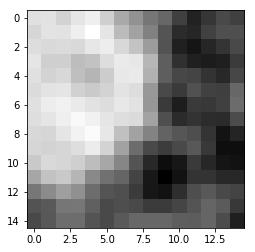

5184


In [60]:
plt.imshow(all_patches[5], cmap="gray")
plt.show()
print(len(all_patches))

In [62]:
patch_size = 25
patches_dic = extract_all_patches(main_directory, patch_size)

MemoryError: 

In [38]:
nbs_patch = []
for patient in patches_dic:
    nbs_patch.append(len(patches_dic[patient]))

In [39]:
print(np.min(nbs_patch))
print(np.max(nbs_patch))
print(np.median(nbs_patch))

0
180788
1890.0


In [ ]:
patches_dic.keys()

In [56]:
some_string = 'ttesith_jdfslk'
some_string.split('_')[1]

'jdfslk'